# Algorytmy geometryczne – ćwiczenie 2 - otoczka wypukła

Implementacja algorytmów Grahama i Jarvisa wraz z wizualizacją przebiegu algorytmu i pomiarem czasu dla różnych zestawów danych wejściowych.

### Importy

In [32]:
from geometria import *
from random import seed, uniform, random, choice
from math import sin, cos, pi, inf
from time import time
import os

### Wygenerowanie punktów

A: 100 losowo wygenerowanych punktów o współrzędnych z przedziału [-100, 100]

<IPython.core.display.Javascript object>


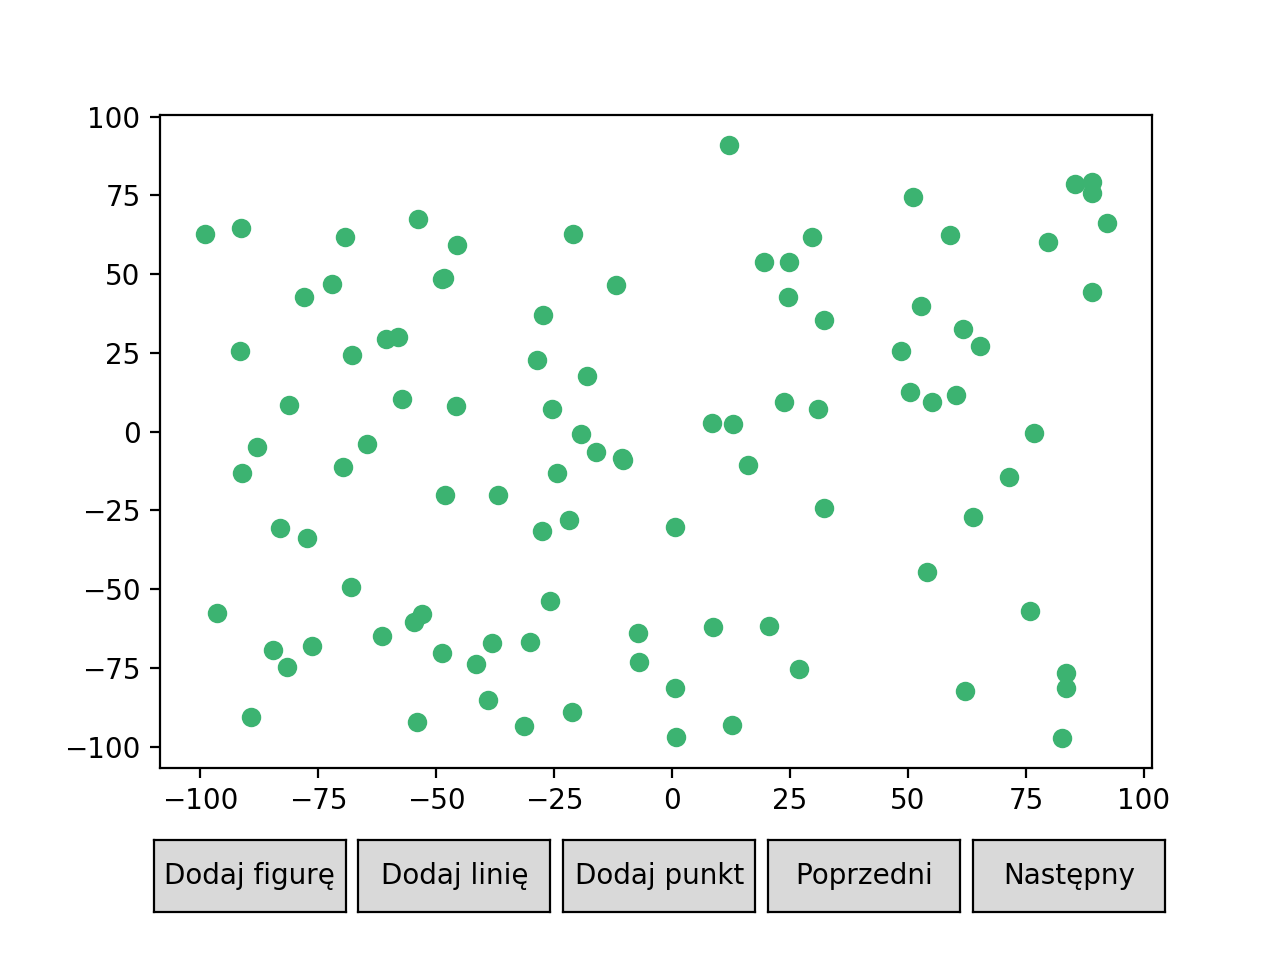

In [33]:
%matplotlib notebook
seed(144)
points_A = [(uniform(-100, 100), uniform(-100, 100)) for _ in range(100)]
Plot(points = [PointsCollection(points_A, color='mediumseagreen')]).draw()

B: 100 losowo wygenerowanych punktów leżących na okręgu o środku (0,0) i promieniu R=10

<IPython.core.display.Javascript object>


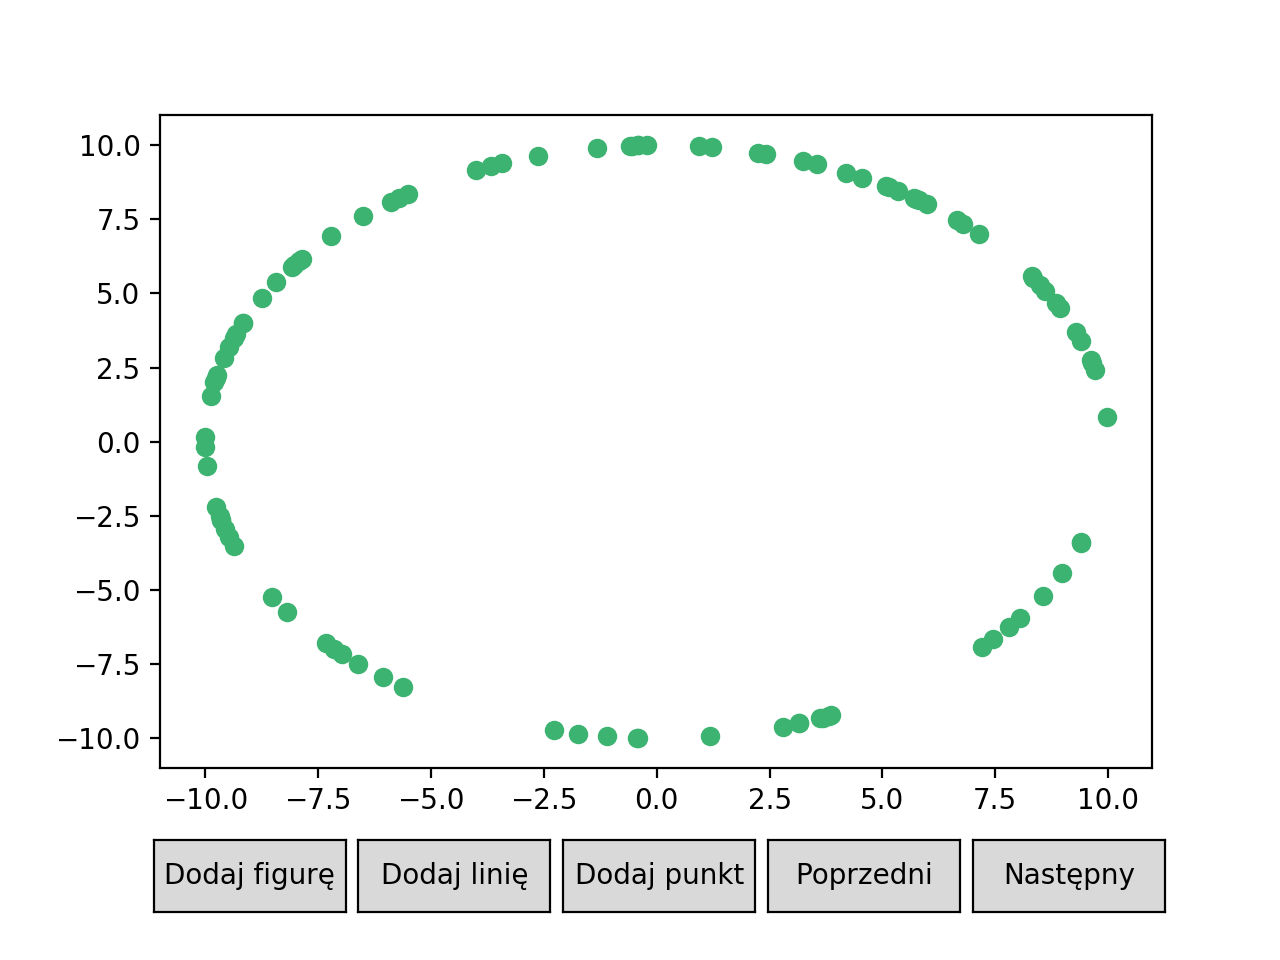

In [34]:
seed(144)
points_B = [(10*cos(2*pi*t), 10*sin(2*pi*t)) for t in [random() for _ in range(100)]]
Plot(points = [PointsCollection(points_B, color='mediumseagreen')]).draw()

C: 100 losowo wygenerowanych punktów leżących na bokach prostokąta
o wierzchołkach (-10, 10), (-10,-10), (10,-10), (10,10),

<IPython.core.display.Javascript object>


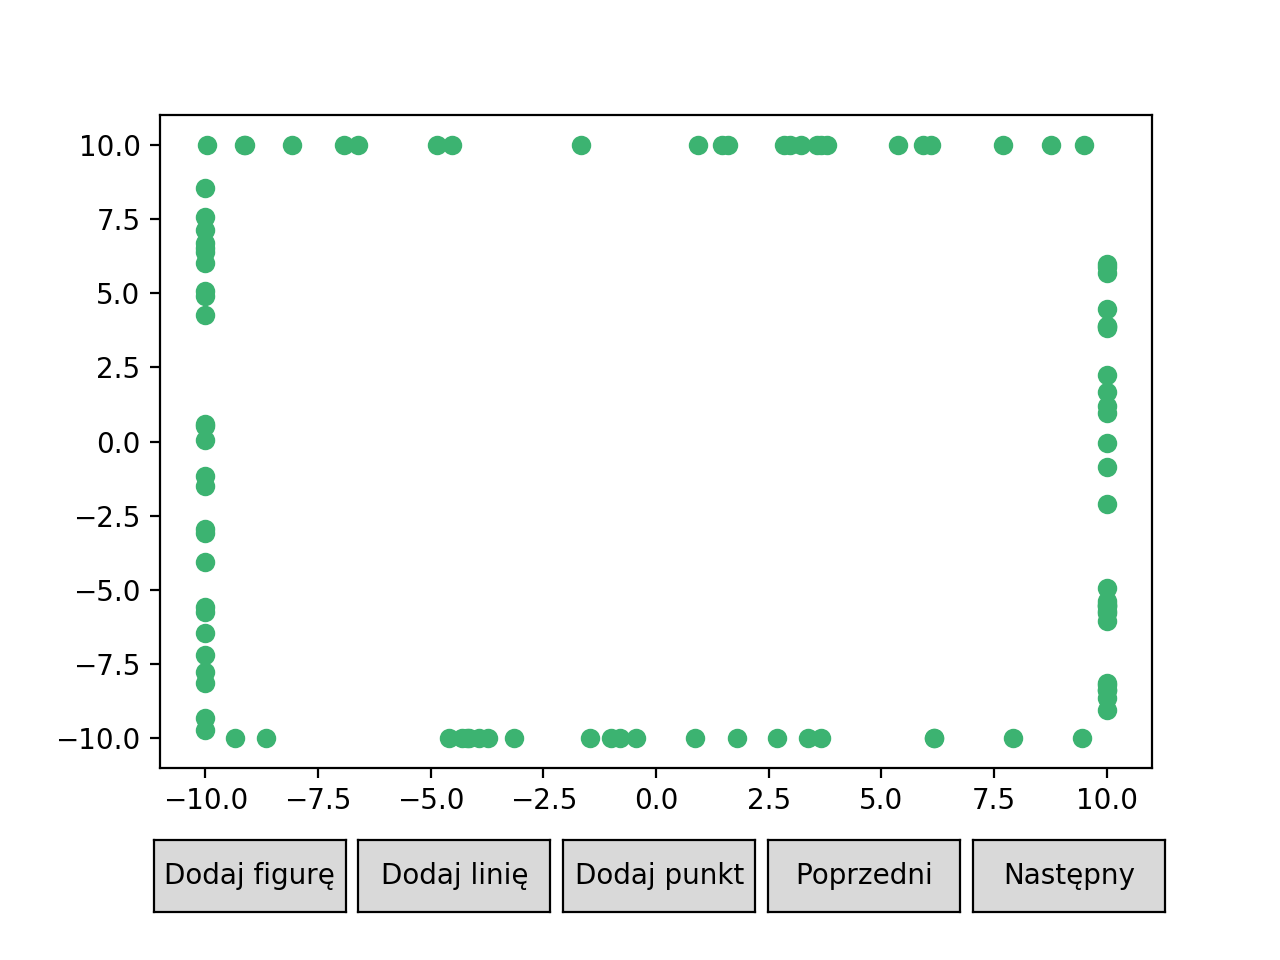

In [35]:
seed(144)
points_C = []
for _ in range(100):
    if random() < 0.5:
        points_C.append((choice((-10,10)), uniform(-10,10)))
    else:
        points_C.append((uniform(-10,10), choice((-10,10))))
Plot(points = [PointsCollection(points_C, color='mediumseagreen')]).draw()

D: wierzchołki kwadratu (0, 0), (10, 0), (10, 10), (0, 10) oraz punkty
wygenerowane losowo w sposób następujący: po 25 punktów na dwóch bokach
kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu.

<IPython.core.display.Javascript object>


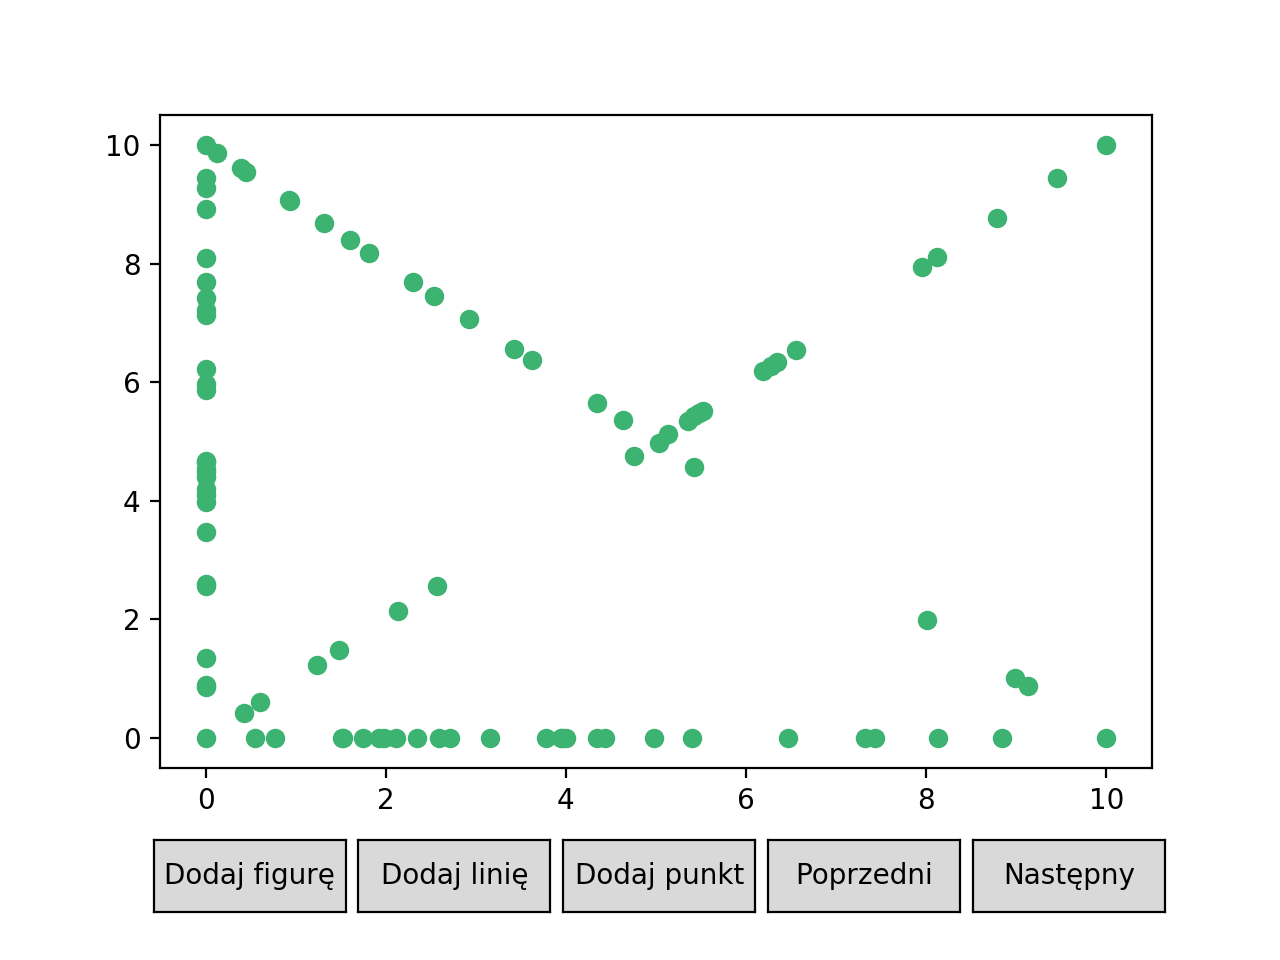

In [36]:
points_D = [(0,0), (10,0), (10,10), (0,10)] #wierzchołki kwadratu
seed(144)

for _ in range(25): #boki na osiach
    points_D.append((0, uniform(0,10)))
for _ in range(25): #boki na osiach
    points_D.append((uniform(0,10), 0))

points_D.extend([(x, x) for x in [uniform(0,10) for _ in range(20)]]) #przekątna 1.
points_D.extend([(x, 10-x) for x in [uniform(0,10) for _ in range(20)]]) #przekątna 2.

Plot(points = [PointsCollection(points_D, color='mediumseagreen')]).draw()

### Funkcje do generowania punktów o określonych parametrach

typ A: punkty z zadanego zakresu

<IPython.core.display.Javascript object>


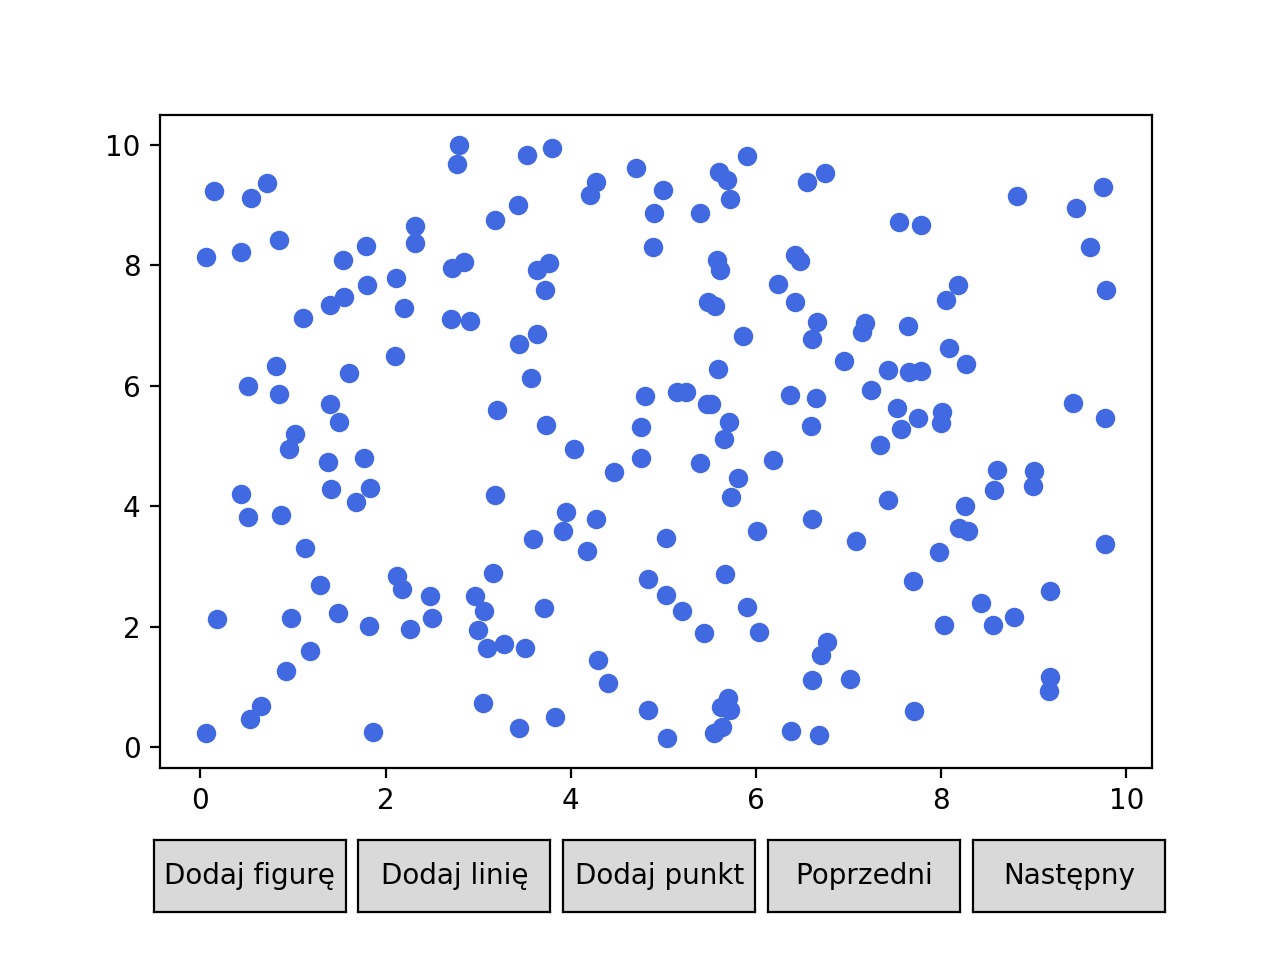

In [37]:
def generate_points_range(num_points, in_range):
    a, b = in_range
    return [(uniform(a, b), uniform(a, b)) for _ in range(num_points)]

points_range = generate_points_range(200, (0, 10))
Plot(points = [PointsCollection(points_range, color='royalblue')]).draw()

typ B: punkty na okręgu

<IPython.core.display.Javascript object>


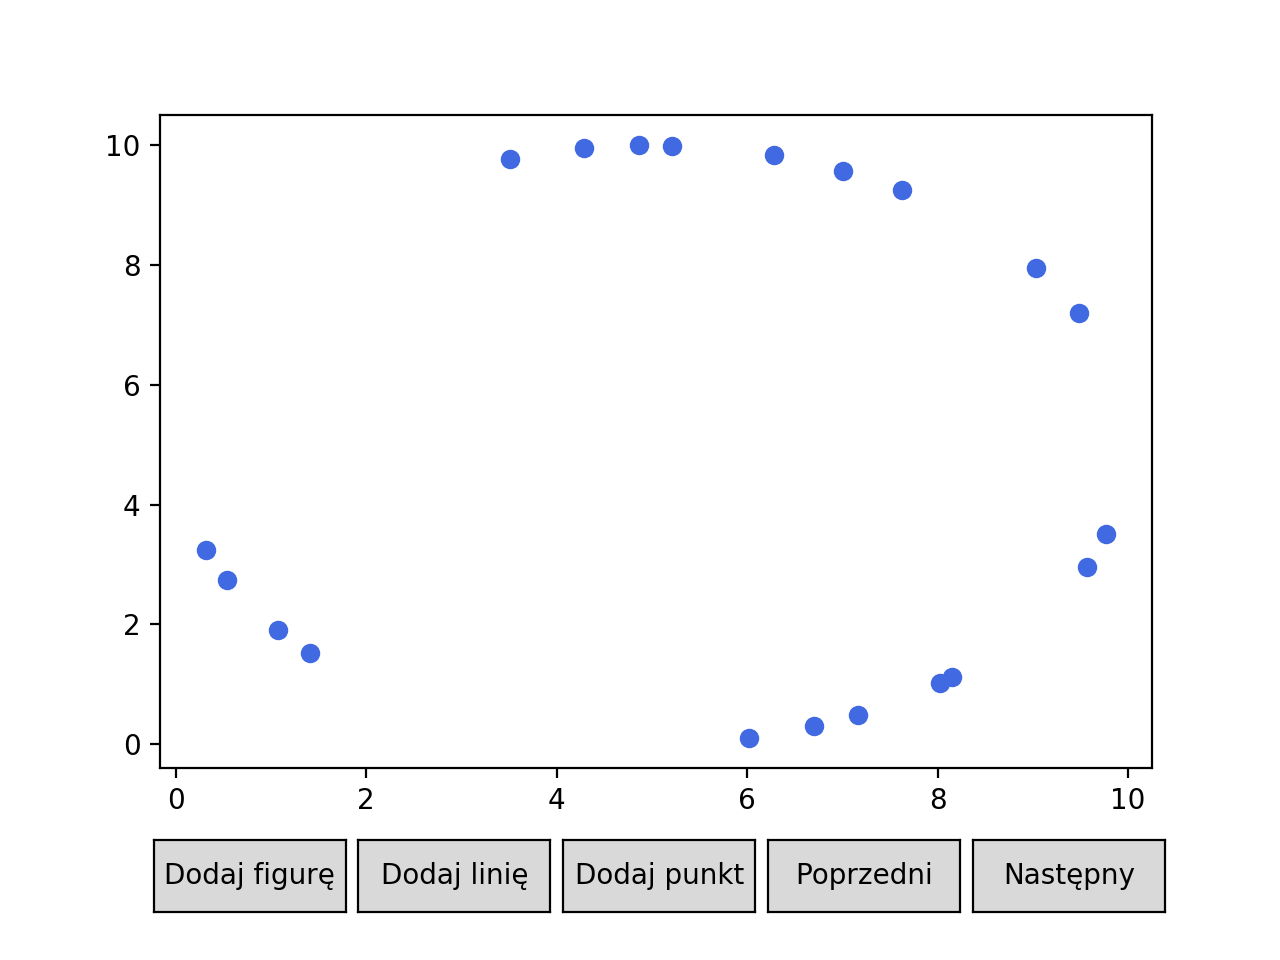

In [38]:
def generate_points_circle(num_points, center, radius):
    x, y = center
    return [(x + radius*cos(2*pi*t), y + radius*sin(2*pi*t)) for t in [random() for _ in range(num_points)]]

points_circle = generate_points_circle(20, (5, 5), 5)
Plot(points = [PointsCollection(points_circle, color='royalblue')]).draw()


typ C: punkty na bokach prostokąta

<IPython.core.display.Javascript object>


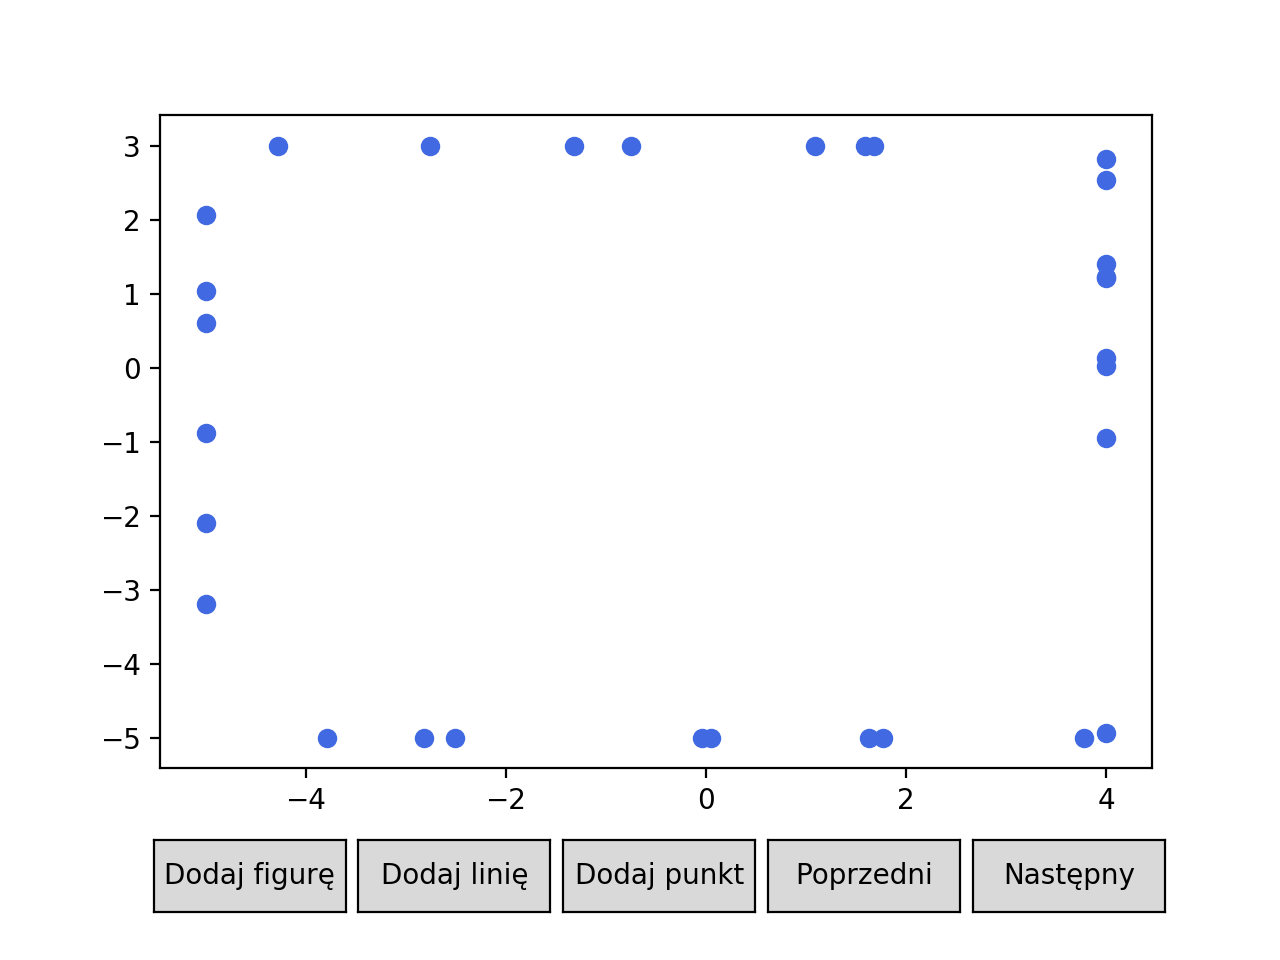

In [39]:
def generate_points_rectangle(num_points, vertices):
    points = []
    x_min = min(vertices, key=lambda x: x[0])[0]
    x_max = max(vertices, key=lambda x: x[0])[0]
    
    y_min = min(vertices, key=lambda x: x[1])[1]
    y_max = max(vertices, key=lambda x: x[1])[1]
    
    for _ in range(num_points):
        if random() < 0.5:
            points.append((choice((x_min, x_max)), uniform(y_min, y_max)))
        else:
            points.append((uniform(x_min, x_max), choice((y_min, y_max))))
    return points

points_rectangle = generate_points_rectangle(30, [(-5, -5), (4, -5), (4,3), (-5, 3)])
Plot(points = [PointsCollection(points_rectangle, color='royalblue')]).draw()

typ D: punkty na bokach kwadratu (na osiach) i na przekątnych

<IPython.core.display.Javascript object>


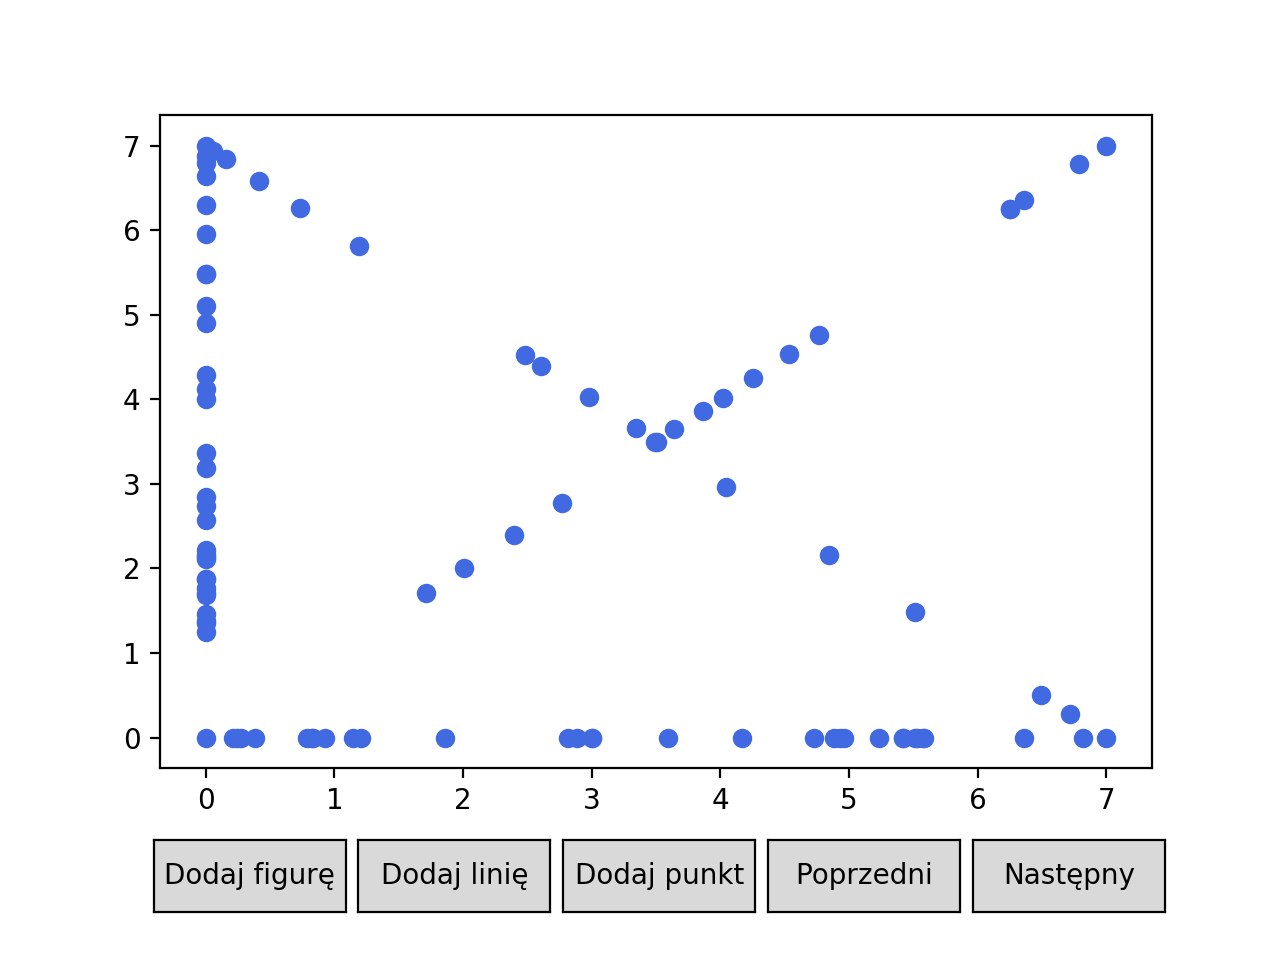

In [40]:
def generate_points_square(side_length, num_on_axis, num_on_diag):
    points = [(0,0), (0, side_length), (side_length, 0), (side_length, side_length)]
    for _ in range(num_on_axis): # oś pionowa
        points.append((0, uniform(0, side_length)))
    for _ in range(num_on_axis): # oś pozioma
        points.append((uniform(0,side_length), 0))

    points.extend([(x, x) for x in [uniform(0,side_length) for _ in range(num_on_diag)]]) #przekątna 1.
    points.extend([(x, side_length-x) for x in [uniform(0,side_length) for _ in range(num_on_diag)]]) #przekątna 2.
    return points


points_square = generate_points_square(7, 30, 15)
Plot(points = [PointsCollection(points_square, color='royalblue')]).draw()

### Funkcje pomocnicze

Wyznacznik metodą Sarussa:

In [41]:
def det(a, b, c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - b[0]*a[1] - c[1]*a[0]

Odległość euklidesowa punktów w 2D:

In [42]:
def dist(a, b):
    return (b[0]-a[0])**2 + (b[1]-a[1])**2

Tolerancja względem zera z uwagi na stosowanie wyznacznika do określenia pozycji względnej punktu:

In [43]:
epsilon = 1e-12

### Algorytm Grahama

Funkcja sortująca oparta na algorytmie sortowania szybkiego Quicksort, wykorzystująca wyznacznik

In [44]:
def sort_points(t, p0, a, b):  
    '''
    t -> tablica do posortowania (modyfikuje przekazaną tablicę)
    p0 -> punkt względem którego sortujemy
    a, b -> liczby naturalne określające przedział aktualnie sortowany
    '''
    
    pivot = t[b]
    i = a

    for j in range(a, b):
        if det(p0, t[j], pivot) > epsilon:
            t[i], t[j] = t[j], t[i]
            i += 1

    t[b], t[i] = t[i], t[b]
    if i > a: sort_points(t, p0, a, i-1)
    if i < b: sort_points(t, p0, i+1, b)

Funkcja usuwająca punkt bliższy p0, dla par punktów współliniowych z p0

In [45]:
def keep_furthest_coll(points, p0):
    '''
    points -> tablica punktów do zredukowania
    p0 -> punkt, względem którego określamy współliniowość dwóch innych punktów
    '''
    i = 0
    while i < len(points)-1:
        if epsilon >= det(p0, points[i], points[i+1]) >= -epsilon:
            if dist(p0, points[i]) < dist(p0, points[i+1]):
                    points.pop(i)
            else:
                points.pop(i+1)
        else:
                i += 1
                
    return points

Implementacja algorytmu Grahama:

In [46]:
def graham(points_data, save_to_file=None):
    '''
    points_data -> lista punktów [(double, double)] dla których szukamy otoczki
    
    funkcja zwraca listę wierzchołków należących do otoczki w kolejności przeciwnej do ruchu wskazówek zegara
    oraz czas działania programu w sekundach
    
    '''
    start = time()
    
    # wybranie punktu p0 i usunięcie go ze zbioru
    y_min = min(points_data, key=lambda x: x[1])[1]
    lowest_points = [point for point in points_data if point[1]==y_min]
    p0 = min(lowest_points, key=lambda x: x[0])
    points = [point for point in points_data if point != p0]
    
    # sortowanie i redukcja punktów współliniowych
    sort_points(points, p0, 0, len(points)-1)
    points = keep_furthest_coll(points, p0)
    
    
    # główna część algorytmu
    stack = [p0, points[0], points[1]]
    
    i = 2
    while i < len(points): 
        if det(stack[-2], stack[-1], points[i]) > epsilon:
            stack.append(points[i])
            i += 1
        else:
            stack.pop()
    
    end = time()
    
    if not save_to_file is None:
        with open(save_to_file, 'a') as file:
            file.write(str(stack))
    
    return stack, end-start

Funkcja do wizualizacji algorytmu Grahama:

In [47]:
def graham_visualization(points_data):
    '''
    points_data -> lista punktów do znalezienia otoczki
    
    funkcja zwraca listę scen klasy Scene, do dynamicznej wizualizacji algorytmu
    
    '''
    y_min = min(points_data, key=lambda x: x[1])[1]
    lowest_points = [point for point in points_data if point[1]==y_min]
    p0 = min(lowest_points, key=lambda x: x[0])
    points = [point for point in points_data if point != p0]
    
    
    sort_points(points, p0, 0, len(points)-1)
    points = keep_furthest_coll(points, p0)
    
    scenes = [Scene([PointsCollection(points_data, color='dimgray')]), Scene([PointsCollection(points_data, color='lightgray'), PointsCollection(points, color='dimgray'), PointsCollection([p0], color='red')])]
    
    stack = [p0, points[0], points[1]]
    
    i = 2
    while i < len(points):          
        scenes.append(Scene([PointsCollection(points_data, color='lightgray'), PointsCollection(points, color='dimgray'), 
                             PointsCollection(stack[:], color = 'maroon'), 
                             PointsCollection([points[i]], color='red')],
                     [LinesCollection([(stack[i], stack[i+1]) for i in range(len(stack)-1)], color='maroon'), 
                      LinesCollection([(stack[-1], points[i])], color='blue')]))
        
        PointsCollection([points[i]], color='red')
        
        if det(stack[-2], stack[-1], points[i]) > epsilon:
            stack.append(points[i])
            i += 1
        else:
            stack.pop()
    
    
    convex_hull = [(stack[i], stack[(i+1)%len(stack)]) for i in range(len(stack))]
    
    scenes.append(Scene([PointsCollection(points_data, color='dimgray'), 
                             PointsCollection(stack[:], color = 'maroon')],
                     [LinesCollection(convex_hull, color='maroon')]))
    
    
    return scenes

In [48]:
graham(points_D, save_to_file='plik')

([(0, 0), (10, 0), (10, 10), (0, 10)], 0.0015590190887451172)

<IPython.core.display.Javascript object>


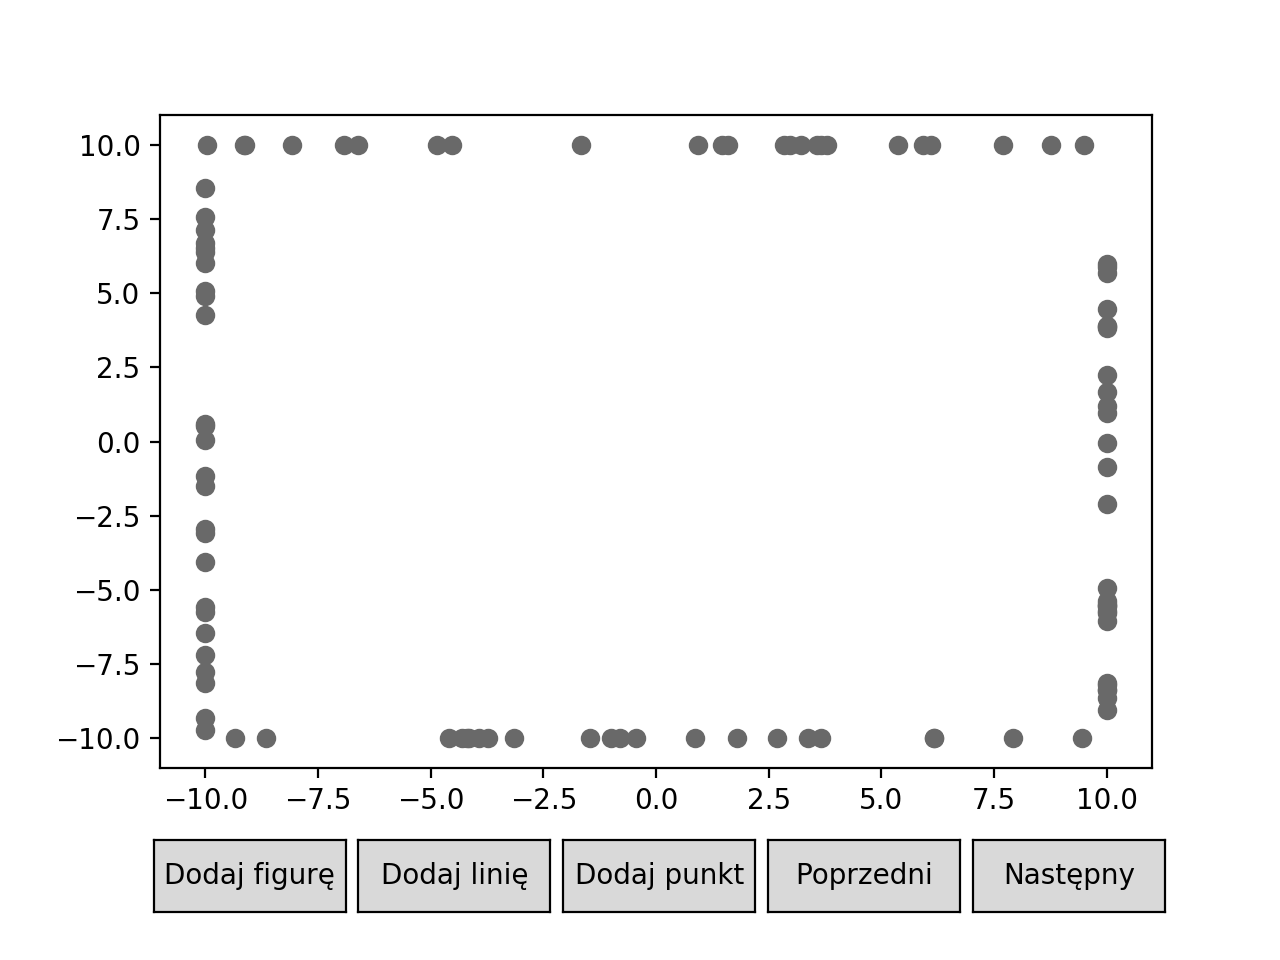

In [49]:
plot = Plot(scenes=graham_visualization(points_C))
plot.draw()

<IPython.core.display.Javascript object>


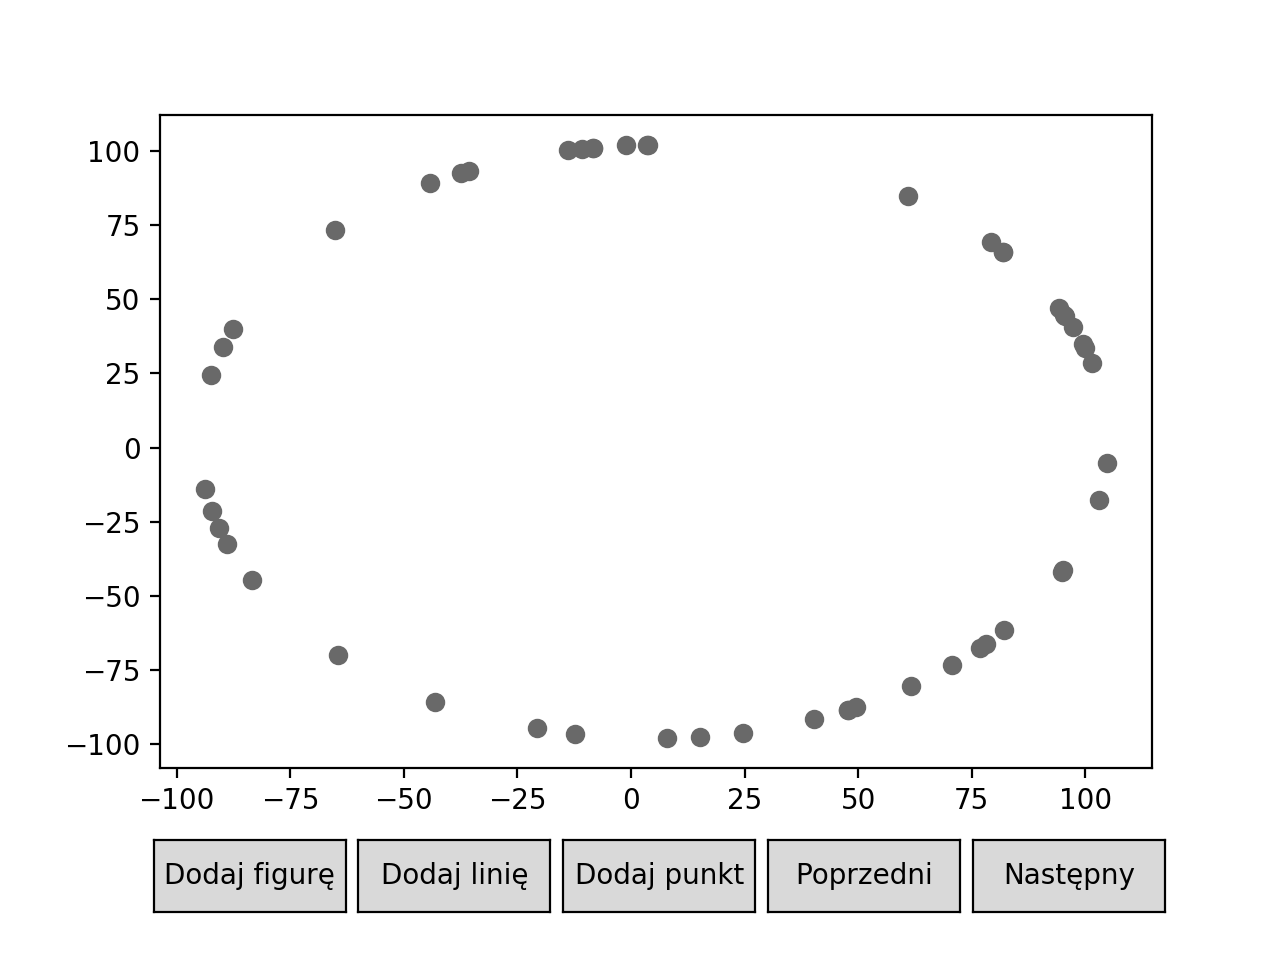

In [50]:
plot = Plot(scenes=graham_visualization(generate_points_circle(50, (5,2), 100)))
plot.draw()

### Algorytm Jarvisa

Funkcja znajdująca punkt o najmniejszym kącie liczonym przeciwnie do ruchu wskazówek zegara względem zadanej krawędzi.
<br>Funkcja korzysta wyznacznika do wybrania minimum.

In [51]:
def min_angle(points, a, b):
    '''
    points -> punkty z których wybieramy punkt o najmniejszym kącie
    a -> początek ostatniej krawędzi
    b -> koniec ostatniej krawędzi
    
    zwraca punkt o najmniejszym kącie, funkcja wykorzystuje wyznacznik zamiast liczenia kąta
    '''
    for point in points:
        if point != a and point != b:
            min_ = point
            break
    
    for point in points:
        if point == a or point == b:
            continue
        det_ = det(a, b, point)
        if det_ > -epsilon: # nie rozpatrujemy punktów na prawo od prostej
            d = det(b, min_, point)
            if epsilon > d > -epsilon and dist(b, point) > dist(b, min_): #współliniowe
                min_ = point
            elif det(b, min_, point) < -epsilon: # na lewo od prostej, na prawo od punktu min_ -> nowe min_
                min_ = point
     
    return min_

Funkcja usuwająca punkty leżące na nowej krawędzi, aby nie rozważać niepotrzebnie niektórych punktów przy wyznaczaniu min_angle. Zastosowanie funkcji nie zmienia rzędu złożoności algorytmu, ale potencjalnie może program przyspieszyć.

In [52]:
def keep_relevant_points(points, a, b, p1):
    '''
    funkcja usuwa punkty z tablicy points leżące na prostej ab, z pominięciem punktu p1
    '''
    i = 0
    while i < len(points):
        if points[i] == p1:
            i += 1
        elif epsilon > det(a,b,points[i]) > -epsilon:
            points.pop(i)
        else:
            i += 1

Implementacja algorytmu Jarvisa:

In [53]:
def jarvis(points_data, save_to_file=None):
    '''
    points_data -> lista punktów, dla których szukamy otoczki
    
    zwraca listę wierzchołków otoczki w kolejności przeciwnej do ruchu wskazówek zegara
    oraz czas działania programu
    
    '''
    
    start = time()
    
    # wyznaczenie punktu p1 o najmniejszym y i x w razie remisu
    y_min = min(points_data, key=lambda x: x[1])[1]
    lowest_points = [point for point in points_data if point[1]==y_min]
    p1 = min(lowest_points, key=lambda x: x[0])
    
    # wirtualny punkt p0 do zerowej krawędzi otoczki, dla rozpoczęcia algorytmu
    p0 = (p1[0]-1, p1[1])
    
    points = points_data[:]
    
    # główna część algorytmu
    convex_hull = [p0, p1]
    
    while True:
        next_point = min_angle(points, convex_hull[-2], convex_hull[-1])
        convex_hull.append(next_point) 
            
        keep_relevant_points(points, convex_hull[-2], convex_hull[-1], p1)
        
        if next_point == p1:
            break
    
    end = time()
    
    if not save_to_file is None:
        with open(save_to_file, 'a') as file:
            file.write(str(convex_hull[1:-1]))
    
    return convex_hull[1:-1], end-start

In [54]:
def jarvis_visualization(points_data):
    '''
    points_data -> lista punktów do znalezienia otoczki
    
    funkcja zwraca listę scen klasy Scene, do dynamicznej wizualizacji algorytmu
    '''

    y_min = min(points_data, key=lambda x: x[1])[1]
    lowest_points = [point for point in points_data if point[1]==y_min]
    p1 = min(lowest_points, key=lambda x: x[0])
    p0 = (p1[0]-1, p1[1])
    
    points = points_data[:]
    

    scenes = [Scene([PointsCollection(points_data, color='dimgray')]), Scene([PointsCollection(points_data, color='lightgray'),
                                                                               PointsCollection(points[:], color='dimgray'),
                                                                               PointsCollection([p1], color='red')])]
    
    convex_hull = [p0, p1]
    
    while True:
        next_point = min_angle(points, convex_hull[-2], convex_hull[-1])
        convex_hull.append(next_point) 
            
        keep_relevant_points(points, convex_hull[-2], convex_hull[-1], p1)
            
        scenes.append(Scene([PointsCollection(points_data, color='lightgray'), 
                             PointsCollection(points[:], color='dimgray'),
                             PointsCollection(convex_hull[1:], color = 'maroon'), 
                             PointsCollection([next_point], color='red')],
                     [LinesCollection([(convex_hull[i], convex_hull[i+1]) for i in range(1, len(convex_hull)-1)], color='maroon'), 
                    LinesCollection([(convex_hull[-1], next_point)], color='blue')]))
        
        if next_point == p1:
            break
        
    return scenes

In [55]:
jarvis(points_D)

([(0, 0), (10, 0), (10, 10), (0, 10)], 0.0013959407806396484)

<IPython.core.display.Javascript object>


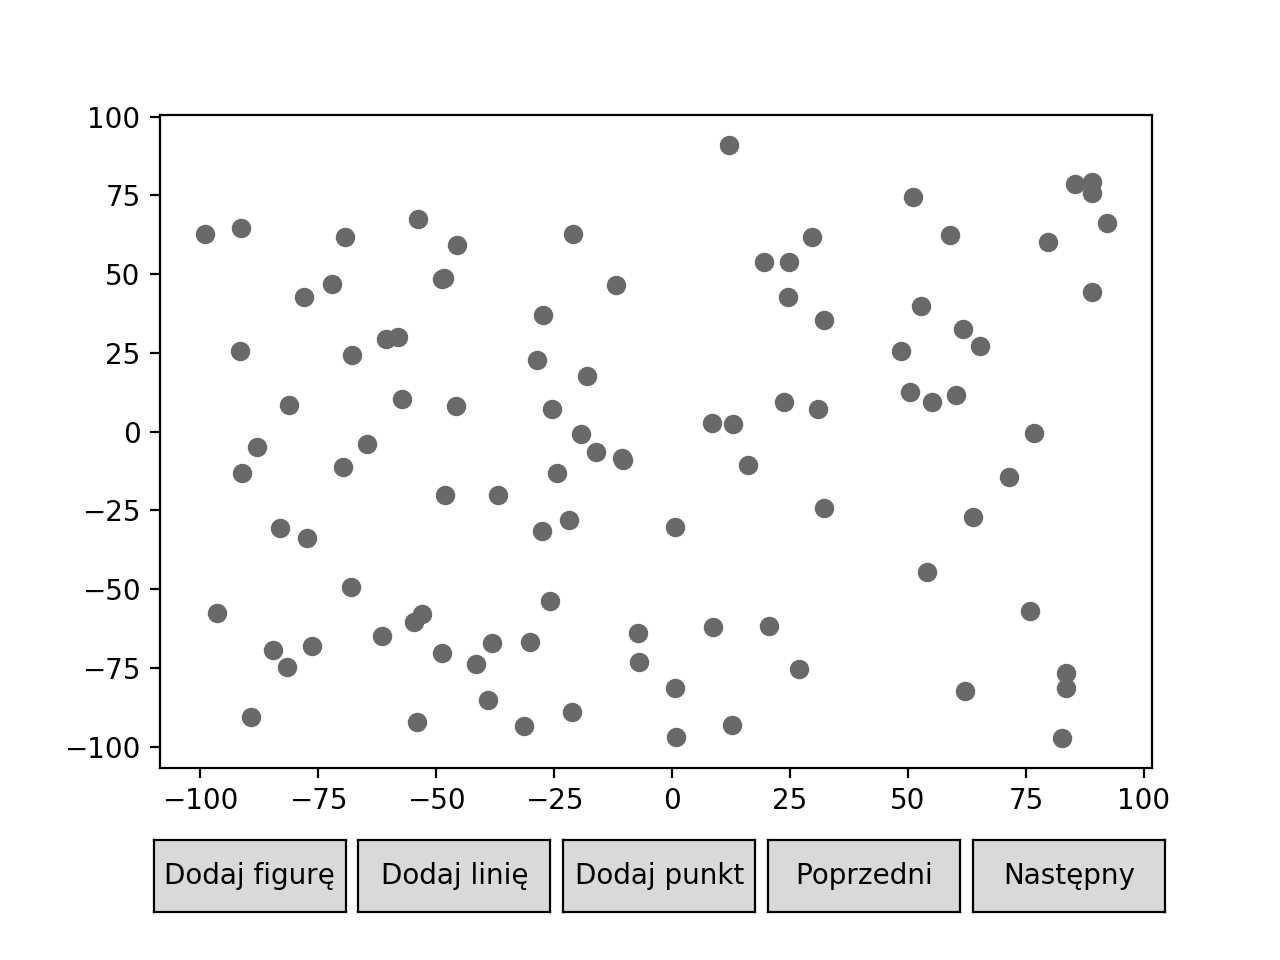

In [56]:
plot = Plot(scenes=jarvis_visualization(points_A))
plot.draw()

<IPython.core.display.Javascript object>


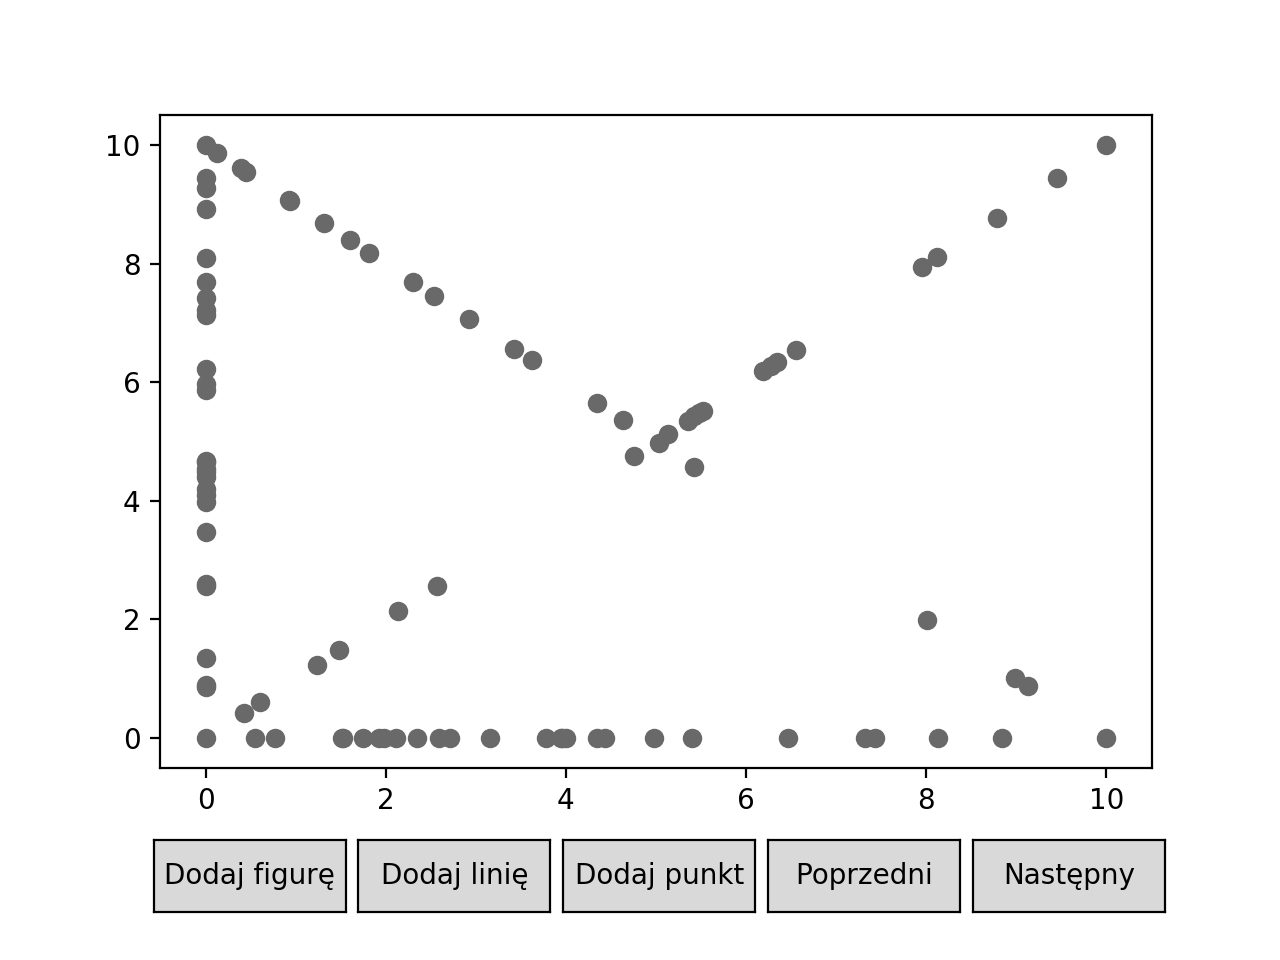

In [57]:
plot = Plot(scenes=jarvis_visualization(points_D))
plot.draw()

### Animacja

Funkcja save_png zapisuje do folderu pliki png z poszczególnymi krokami algorytmu. Obrazki te wykorzystam następnie do utworzenia animacji/gifa w osobnym programie.

In [58]:
def save_png(points, points_name, alg):
    '''
    points -> zestaw punktów do znalezienia otoczki
    points_name -> nazwa zestawu punktów do odpowiedniego nazwania folderu
    alg -> 'g' lub 'j' : odpowiednio graham i jarvis
    
    zapisuje pliki png z poszczególnymi krokami wizualizacji do folderu
    '''
    if alg == 'g':
        scenes = graham_visualization(points)
    elif alg == 'j':
        scenes = jarvis_visualization(points)
    else:
        return
    
    directory = f'{points_name}_{alg}_vis'
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for i in range(len(scenes)):
        Plot(scenes=[scenes[i]]).draw()
        plt.savefig(f'{directory}/{i}.png')

In [59]:
# save_png(points_D, 'points_D', 'g')
# save_png(points_D, 'points_D', 'j')
# save_png(points_A, 'points_A', 'g')
# save_png(points_A, 'points_A', 'j')

Na jasnoszaro zaznaczone są punkty, które nie są już rozpatrywane przez algorytm

<center>
<h2>A</h2>
<h3>Graham:</h3>
<img src="animacje/graham_a.gif" title="graham_a.gif">
<h3>Jarvis:</h3>
<img src="animacje/jarvis_a.gif" title="jarvis_a.gif">
<h2>D</h2>
<h3>Graham:</h3>
<img src="animacje/graham_d.gif" title="graham_d.gif">
<h3>Jarvis:</h3>
<img src="animacje/jarvis_d.gif" title="jarvis_d.gif">
</center>

### Test czasu działania algorytmów dla różnych zbiorów punktów

Analiza wpływu rozpiętości danych: 
* A: wielkość zakresu
* B: promień okręgu
* C: długości boków prostokąta
* D: długość boków kwadratu

W każdym przypadku punktów jest 1000.

In [60]:
seed(144)
points_sets = [('zakres 0-10', generate_points_range(1000, (0,10))),
                ('zakres 0-100', generate_points_range(1000, (0,100))),
                ('zakres 0-1000', generate_points_range(1000, (0,1000))),
               ('koło (0,0) 10', generate_points_circle(1000, (0,0), 10)),
               ('koło (0,0) 100', generate_points_circle(1000, (0,0), 100)),
               ('koło (0,0) 1000', generate_points_circle(1000, (0,0), 1000)),
               ('prostokąt bok=10', generate_points_rectangle(1000, [(0,0), (10,0), (10,10), (0,10)])),
               ('prostokąt bok=100', generate_points_rectangle(1000, [(0,0), (100,0), (100,100), (0,100)])),
               ('prostokąt bok=1000', generate_points_rectangle(1000, [(0,0), (1000,0), (1000,1000), (0,1000)])),
               ('koperta bok=10', generate_points_square(10, 250, 250)),
               ('koperta bok=100', generate_points_square(100, 250, 250)),
               ('koperta bok=1000', generate_points_square(1000, 250, 250)),
               ]

In [61]:
with open('results', 'a') as file:
    file.write('---------rozpiętość--------- \n\n Graham\n\n')
    for name, points in points_sets:
        graham_hull, graham_time = graham(points)
        file.write(f'{name} czas [s] graham: {graham_time}\n\n')
    file.write('\n\n\n')      

In [62]:
with open('results', 'a') as file:
    file.write('---------rozpiętość--------- \n\n Jarvis\n\n')
    for name, points in points_sets:
        jarvis_hull, jarvis_time = jarvis(points)
        file.write(f'{name} czas [s] jarvis: {jarvis_time}\n\n')
    file.write('\n\n\n')

Analiza czasu działania programu dla różnych rozmiarów i typów danych.

In [63]:
seed(144)
points_sets = [
                ('zakres 10', generate_points_range(10, (0,50))),
                ('zakres 100', generate_points_range(100, (0,50))),
                ('zakres 500', generate_points_range(500, (0,50))),
                ('zakres 1000', generate_points_range(1000, (0,50))),
                ('zakres 5000', generate_points_range(5000, (0,50))),
               
                ('koło 10', generate_points_circle(10, (0,0), 50)),
                ('koło 100', generate_points_circle(100, (0,0), 50)),
                ('koło 500', generate_points_circle(500, (0,0), 50)),
                ('koło 1000', generate_points_circle(1000, (0,0), 50)),
                ('koło 5000', generate_points_circle(5000, (0,0), 50)),
               
               
                ('prostokąt 10', generate_points_rectangle(10, [(0,0), (50,0), (50,50), (0,50)])),
                ('prostokąt 100', generate_points_rectangle(100, [(0,0), (50,0), (50,50), (0,50)])),
                ('prostokąt 500', generate_points_rectangle(500, [(0,0), (50,0), (50,50), (0,50)])),
                ('prostokąt 1000', generate_points_rectangle(1000, [(0,0), (50,0), (50,50), (0,50)])),
                ('prostokąt 5000', generate_points_rectangle(5000, [(0,0), (50,0), (50,50), (0,50)])),
               
                ('koperta 10', generate_points_square(50, 2, 3)),
                ('koperta 100', generate_points_square(50, 20, 30)),
                ('koperta 500', generate_points_square(50, 100, 150)),
                ('koperta 1000', generate_points_square(50, 200, 300)),
                ('koperta 5000', generate_points_square(50, 1000, 1500))

               ]

In [64]:
with open('results', 'a') as file:
    file.write('---------rozmiar danych--------- \n\n Graham\n\n')
    for name, points in points_sets:
        graham_hull, graham_time = graham(points)
        file.write(f'{name} czas [s] graham: {graham_time}\n\n')
    file.write('\n\n\n')      

In [ ]:
with open('results', 'a') as file:
    file.write('---------rozmiar danych--------- \n\n Jarvis\n\n')
    for name, points in points_sets:
        jarvis_hull, jarvis_time = jarvis(points)
        file.write(f'{name} czas [s] jarvis: {jarvis_time}\n\n')
    file.write('\n\n\n')

M. Hawryluk, 2020